/Users/jacky/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


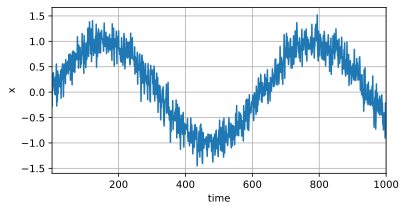

In [1]:
from pyexpat import features
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [2]:
lag_window = 4
features = torch.zeros((T - lag_window, lag_window))
for i in range(lag_window):
    features[:, i] = x[i: T - lag_window + i]
labels = x[lag_window:].reshape(-1, 1)

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [3]:
# 初始化网络权重
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weights)


# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net


# 平方损失函数
loss = nn.MSELoss(reduction='none')

In [4]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.098897
epoch 2, loss: 0.064840
epoch 3, loss: 0.061290
epoch 4, loss: 0.052832
epoch 5, loss: 0.050292


/Users/jacky/Library/Python/3.9/lib/python/site-packages/d2l/torch.py:3179: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  self.data = [a + float(b) for a, b in zip(self.data, args)]


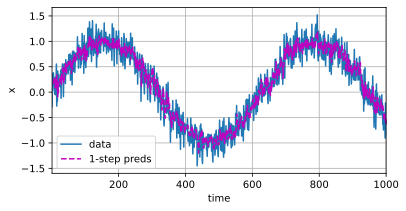

In [6]:
onestep_preds = net(features)
d2l.plot([time, time[lag_window:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

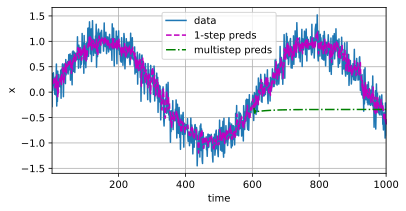

In [8]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + lag_window] = x[: n_train + lag_window]
for i in range(n_train + lag_window, T):
    multistep_preds[i] = net(
        multistep_preds[i - lag_window:i].reshape((1, -1)))

d2l.plot([time, time[lag_window:], time[n_train + lag_window:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + lag_window:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

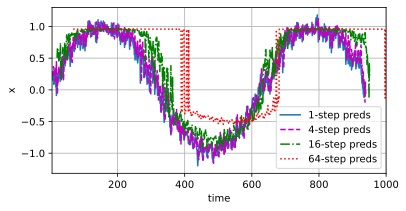

In [10]:
max_steps = 64

features = torch.zeros((T - lag_window - max_steps + 1, lag_window + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(lag_window):
    features[:, i] = x[i: i + T - lag_window - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(lag_window, lag_window + max_steps):
    features[:, i] = net(features[:, i - lag_window:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[lag_window + i - 1: T - max_steps + i] for i in steps],
         [features[:, (lag_window + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))